In [2]:
import numpy as np

from GridCal.Engine import Bus, Load, Line, Generator, MultiCircuit
from GridCal.Engine import PowerFlowOptions, PowerFlowDriver, SolverType

np.set_printoptions(precision=4)

Bentayga is not available
Newton native unavailable


In [3]:
grid = MultiCircuit()

# Add the buses and the generators and loads attached
bus1 = Bus('Bus 1', vnom=20)
# bus1.is_slack = True
grid.add_bus(bus1)

gen1 = Generator('Slack Generator', voltage_module=1.0)
grid.add_generator(bus1, gen1)

bus2 = Bus('Bus 2', vnom=20)
grid.add_bus(bus2)
grid.add_load(bus2, Load('load 2', P=40, Q=20))

bus3 = Bus('Bus 3', vnom=20)
grid.add_bus(bus3)
grid.add_load(bus3, Load('load 3', P=25, Q=15))

bus4 = Bus('Bus 4', vnom=20)
grid.add_bus(bus4)
grid.add_load(bus4, Load('load 4', P=40, Q=20))

bus5 = Bus('Bus 5', vnom=20)
grid.add_bus(bus5)
grid.add_load(bus5, Load('load 5', P=50, Q=20))

# add branches (Lines in this case)
grid.add_line(Line(bus1, bus2, 'line 1-2', r=0.05, x=0.11, b=0.02))
grid.add_line(Line(bus1, bus3, 'line 1-3', r=0.05, x=0.11, b=0.02))
grid.add_line(Line(bus1, bus5, 'line 1-5', r=0.03, x=0.08, b=0.02))
grid.add_line(Line(bus2, bus3, 'line 2-3', r=0.04, x=0.09, b=0.02))
grid.add_line(Line(bus2, bus5, 'line 2-5', r=0.04, x=0.09, b=0.02))
grid.add_line(Line(bus3, bus4, 'line 3-4', r=0.06, x=0.13, b=0.03))
grid.add_line(Line(bus4, bus5, 'line 4-5', r=0.04, x=0.09, b=0.02))

In [4]:
options = PowerFlowOptions(SolverType.NR, verbose=False)
power_flow = PowerFlowDriver(grid, options)
power_flow.run()

In [5]:
print('\n\n', grid.name)
print('\t|V|:', abs(power_flow.results.voltage))
print('\t|Sbranch|:', abs(power_flow.results.Sf))
print('\t|loading|:', abs(power_flow.results.loading) * 100)
print('\terr:', power_flow.results.error)
print('\tConv:', power_flow.results.converged)



 
	|V|: [1.     0.9553 0.9548 0.9333 0.9534]
	|Sbranch|: [49.8051 49.6978 76.058   0.464   5.0627 19.6677 24.6214]
	|loading|: [4980.5128 4969.7819 7605.7981   46.4042  506.2687 1966.7722 2462.1446]
	err: 1.8965827353056852e-08
	Conv: True


In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

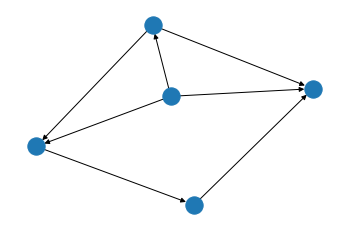

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

grid.plot_graph(ax=ax) # figure located at `fig`